In [ ]:
ACCESS_TOKEN_HUGGINGFACE = "ur_token"

# Prepare data

In [1]:
!pip install evaluate
!pip install faiss-cpu
!pip install rouge_score
!pip install bert-score
# !pip install transformers==4.45.1
!pip install kaggle-environments==1.14.14
# !pip install sentence-transformers==2.2.2
# !pip install trl==0.7.4
!pip install transformers==4.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 60.9 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f8ae106c3f4777cab6863722e2bfb63ab94b7d88cf866b198a4831c38e8c5553
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:0000:01
  Attempting uninstall: kaggle-environments
    Found existing installation: kaggle-environments 1.14.15
    Uninstalling kaggle-environments-1.14.15:
      Successfully uninstalled kaggle-environments-1.14.15
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import transformers
# import trl
# import sentence_transformers
print("Transformers version:", transformers.__version__)
# print("TRL version:", trl.__version__)
# print("sentence_transformers version:", sentence_transformers.__version__)

Transformers version: 4.31.0


In [8]:
import xml.etree.ElementTree as ET
from datasets import Dataset
import os

def process_xml_files(file_paths):
    """
    Hàm xử lý danh sách file XML và trả về Dataset chứa các cặp câu hỏi và câu trả lời.
    
    Args:
        file_paths (list of str): Danh sách các đường dẫn tới file XML.
    
    Returns:
        Dataset: Dataset chứa các cặp câu hỏi và câu trả lời.
    """
    data = []

    for file_path in file_paths:
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()

            for conversation in root.findall("CONVERSATION"):
                # Lấy thuộc tính của CONVERSATION
                conversation_id = conversation.get("id", "N/A")
                article = conversation.get("article", "N/A")

                questions = [q.text.strip() for q in conversation.findall("QUESTIONS/QUESTION") if q.text]

                # print(f"\nProcessing CONVERSATION ID: {conversation_id}, Article: {article}")

                for answer in conversation.findall("ANSWERS/ANSWER"):
                    answer_text = answer.text.strip() if answer.text else ""
                    answer_clause = answer.get("clause", "N/A")  # Lấy thuộc tính clause trong ANSWER
                    answer_point = answer.get("point", "N/A")  # Lấy thuộc tính point trong ANSWER
                    
                    # Kiểm tra nếu answer không bắt đầu bằng "Điều", "Khoản" hoặc "Theo"
                    if not answer_text.startswith(("Điều", "Khoản", "Theo")):
                        if article != "N/A":
                            if answer_clause != "N/A":
                                if answer_point != "N/A":
                                    answer_text = f"Theo Điểm {answer_point}, Khoản {answer_clause}, Điều {article}, {answer_text}"
                                else:
                                    answer_text = f"Theo Khoản {answer_clause}, Điều {article}, {answer_text}"
                            else:
                                answer_text = f"Theo Điều {article}, {answer_text}"
                        else:
                            answer_text = f"Theo Bộ Luật Dân Sự 2015, {answer_text}"
                    
                    # # In thông tin mỗi câu trả lời một lần
                    # print(f" → ANSWER: {answer_text}, Clause: {answer_clause}, Point: {answer_point}")
                    
                    for question in questions:
                        data.append({
                            "conversation_id": conversation_id,
                            "article": article,
                            "clause": answer_clause,  # Thuộc tính clause từ ANSWER
                            "point": answer_point,  # Thuộc tính point từ ANSWER
                            "question": question,
                            "answer": answer_text  # Câu trả lời đã được chỉnh sửa nếu cần
                        })

        except ET.ParseError:
            print(f"Lỗi phân tích cú pháp XML: {file_path}")
        except Exception as e:
            print(f"Lỗi không xác định với file {file_path}: {e}")

    return Dataset.from_list(data) if data else None

# Đọc danh sách file XML
folder_path = "/kaggle/input/xml-data-luat-qa"
xml_files = [os.path.join(root, file) for root, _, files in os.walk(folder_path) for file in files if file.endswith(".xml")]

# Tạo Dataset
dataset = process_xml_files(xml_files)

In [9]:
dataset[10:15]

{'conversation_id': ['2', '2', '3', '3', '3'],
 'article': ['579', '579', '580', '580', '580'],
 'clause': ['2', '2', '1', '1', '1'],
 'point': ['N/A', 'N/A', 'N/A', 'N/A', 'N/A'],
 'question': ['Nhặt được tiền mà không trả thì có sao không?',
  'Nghĩa vụ hoàn trả khi được lợi về tài sản mà không có căn cứ pháp luật được quy định như thế nào?',
  'Phải trả lại những gì khi chiếm giữ hoặc sử dụng tài sản không có căn cứ pháp luật?',
  'Nếu chiếm đồ của người khác thì phải trả lại những gì?',
  'Tài sản hoàn trả trong trường hợp chiếm hữu, sử dụng không có căn cứ pháp luật được quy định như thế nào?'],
 'answer': ['Theo Khoản 2, Điều 579, Nếu bạn được hưởng lợi về tài sản mà không có căn cứ pháp luật và việc này gây thiệt hại cho người khác, bạn phải hoàn trả khoản lợi đó cho người bị thiệt hại, trừ trường hợp quy định tại Điều 236.',
  'Theo Khoản 2, Điều 579, Nếu bạn được hưởng lợi về tài sản mà không có căn cứ pháp luật và việc này gây thiệt hại cho người khác, bạn phải hoàn trả khoản

Số lượng giá trị trống trong tập huấn luyện:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64
Số lượng giá trị trống trong tập kiểm thử:
 conversation_id    0
article            0
clause             0
point              0
question           0
answer             0
dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


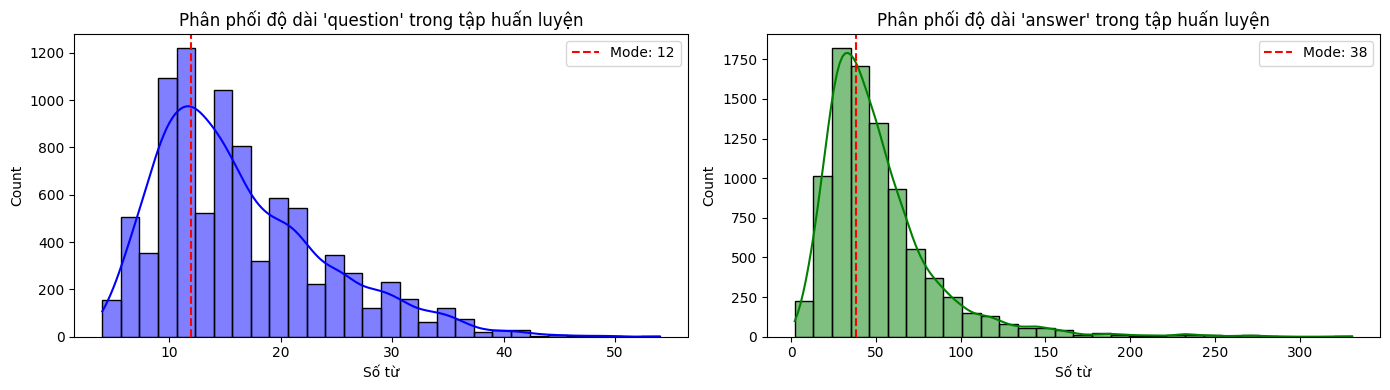

In [10]:
import asyncio
from datasets import load_dataset, Dataset
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq, EarlyStoppingCallback
import torch
import os
import faiss
import pandas as pd
import evaluate
import random
import shutil
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.amp import autocast, GradScaler
import re

# Cấu hình thiết bị và biến môi trường cho multi-GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"  # Sử dụng 2 GPU đầu tiên
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Tải dataset và chuẩn bị tập huấn luyện và tập kiểm thử
# dataset = load_dataset("ducb5523/luat-data")
# dataset = dataset.rename_column("content", "answer")
# dataset = load_dataset("linh5nb/qa_luat_hon_nhan")

# # Đọc file CSV vào Dataset
# dataset = Dataset.from_csv("/kaggle/input/data-luat-qa/data_luat.csv")

# Tách train và test
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Chọn một lượng mẫu cụ thể cho train và eval dataset
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

# # Hàm tách queries, question, và answer
# def extract_text_parts(example):
#     text = example['text']
#     # Tách queries (nội dung trong <<SYS>> và << /SYS>>)
#     queries = re.search(r'<<SYS>>(.*?)<</SYS>>', text, re.DOTALL)
#     queries = queries.group(1).strip() if queries else None
    
#     # Tách question (nội dung sau << /SYS>> và trước [/INST])
#     question = re.search(r'<</SYS>>(.*?)\[/INST\]', text, re.DOTALL)
#     question = question.group(1).strip() if question else None
    
#     # Tách answer (nội dung sau [/INST])
#     answer = re.search(r'\[/INST\](.*)', text, re.DOTALL)
#     answer = answer.group(1).strip() if answer else None
    
#     return {'queries': queries, 'question': question, 'answer': answer}

# # Áp dụng hàm cho train và eval dataset
# train_dataset = train_dataset.map(extract_text_parts)
# eval_dataset = eval_dataset.map(extract_text_parts)

# Chuyển đổi dữ liệu thành DataFrame để dễ xử lý
train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

# Kiểm tra lại số lượng giá trị trống trước khi xử lý
print("Số lượng giá trị trống trong tập huấn luyện:\n", train_df.isnull().sum())
print("Số lượng giá trị trống trong tập kiểm thử:\n", eval_df.isnull().sum())

# # Loại bỏ các cột citation, meta, text
# train_df = train_df.drop(columns=['citation', 'meta', 'text'])
# eval_df = eval_df.drop(columns=['citation', 'meta', 'text'])

# # Loại bỏ các dòng có giá trị thiếu trong cột 'question' và 'answer'
# train_df = train_df.dropna(subset=['question', 'answer'])
# eval_df = eval_df.dropna(subset=['question', 'answer'])

# # Kiểm tra lại số lượng giá trị trống sau khi xử lý
# print("Số lượng giá trị trống trong tập huấn luyện:\n", train_df.isnull().sum())
# print("Số lượng giá trị trống trong tập kiểm thử:\n", eval_df.isnull().sum())

# Tính độ dài của câu hỏi và câu trả lời
train_df['question_length'] = train_df['question'].apply(lambda x: len(x.split()) if x is not None else 0)
train_df['answer_length'] = train_df['answer'].apply(lambda x: len(x.split()) if x is not None else 0)
# train_df['querie_length'] = train_df['queries'].apply(lambda x: len(x.split()) if x is not None else 0)

# Tính giá trị mode (giá trị có tần suất cao nhất)
question_mode = train_df['question_length'].mode()[0]
answer_mode = train_df['answer_length'].mode()[0]
# querie_mode = train_df['querie_length'].mode()[0]

# Vẽ biểu đồ
plt.figure(figsize=(14, 4))

# Biểu đồ phân phối độ dài câu hỏi
plt.subplot(1, 2, 1)
sns.histplot(train_df['question_length'], kde=True, color="blue", bins=30)
plt.title("Phân phối độ dài 'question' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(question_mode, color='red', linestyle='--', label=f'Mode: {question_mode}')
plt.legend()

# Biểu đồ phân phối độ dài câu trả lời
plt.subplot(1, 2, 2)
sns.histplot(train_df['answer_length'], kde=True, color="green", bins=30)
plt.title("Phân phối độ dài 'answer' trong tập huấn luyện")
plt.xlabel("Số từ")
plt.axvline(answer_mode, color='red', linestyle='--', label=f'Mode: {answer_mode}')
plt.legend()

# # Biểu đồ phân phối độ dài ngữ cảnh
# plt.subplot(1, 3, 3)
# sns.histplot(train_df['querie_length'], kde=True, color="purple", bins=30)
# plt.title("Phân phối độ dài 'querie' trong tập huấn luyện")
# plt.xlabel("Số từ")
# plt.axvline(querie_mode, color='red', linestyle='--', label=f'Mode: {querie_mode}')
# plt.legend()

# Hiển thị các biểu đồ
plt.tight_layout()
plt.show()

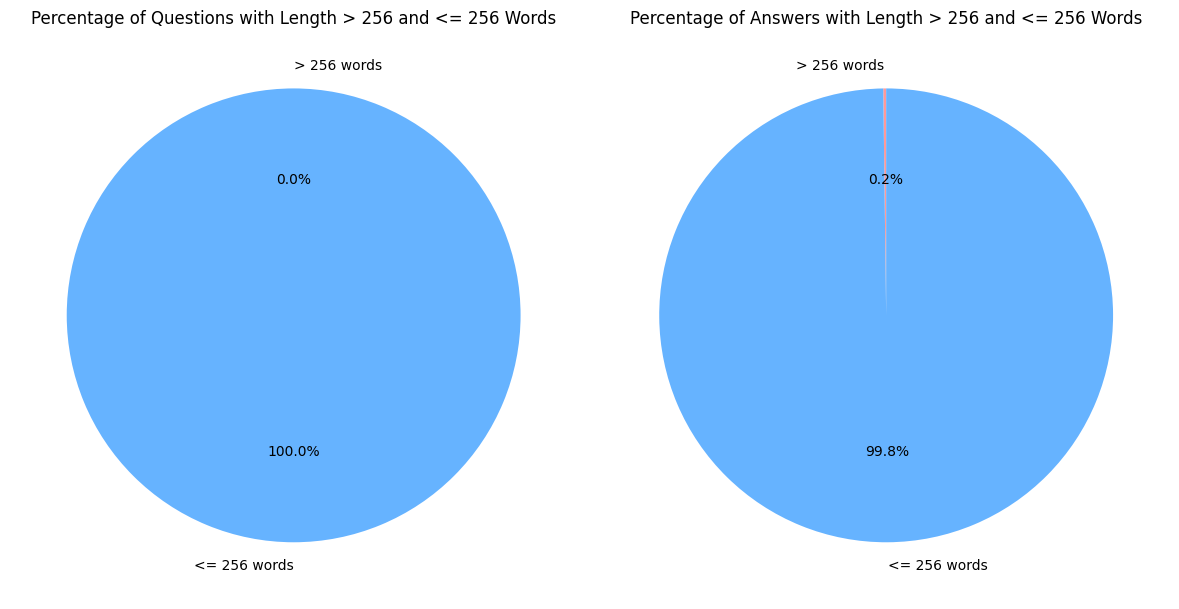

In [11]:
# Thay đổi ngưỡng nếu cần
threshold = 256

# # Tính tổng độ dài của question_length và querie_length
# train_df['combined_question_length'] = train_df['question_length'] + train_df['querie_length']

# Đếm số lượng câu hỏi có độ dài lớn hơn ngưỡng
num_questions_over_threshold = train_df['question_length'].gt(threshold).sum()

# Đếm số lượng câu trả lời có độ dài lớn hơn ngưỡng
num_answers_over_threshold = train_df['answer_length'].gt(threshold).sum()

# Đếm tổng số câu hỏi và câu trả lời
total_questions = len(train_df)
total_answers = len(train_df['answer'])

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài lớn hơn ngưỡng
percentage_questions_over_threshold = (num_questions_over_threshold / total_questions) * 100
percentage_answers_over_threshold = (num_answers_over_threshold / total_answers) * 100

# Tính tỷ lệ phần trăm câu hỏi và câu trả lời có độ dài nhỏ hơn hoặc bằng ngưỡng
percentage_questions_under_threshold = 100 - percentage_questions_over_threshold
percentage_answers_under_threshold = 100 - percentage_answers_over_threshold

# Dữ liệu cho biểu đồ hình tròn
question_data = [percentage_questions_over_threshold, percentage_questions_under_threshold]
answer_data = [percentage_answers_over_threshold, percentage_answers_under_threshold]

# Tạo biểu đồ hình tròn cho câu hỏi
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(question_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Questions with Length > {threshold} and <= {threshold} Words')

# Tạo biểu đồ hình tròn cho câu trả lời
plt.subplot(1, 2, 2)
plt.pie(answer_data, labels=[f'> {threshold} words', f'<= {threshold} words'], autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title(f'Percentage of Answers with Length > {threshold} and <= {threshold} Words')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [12]:
# Hiển thị một vài mẫu dữ liệu
print("\nMột vài mẫu dữ liệu trong tập huấn luyện:")
train_df.sample(5)


Một vài mẫu dữ liệu trong tập huấn luyện:


,conversation_id,article,clause,point,question,answer,question_length,answer_length
6394,31,266,N/A,N/A,Khi chấm dứt quyền hưởng dụng thì phải làm gì ...,"Theo Điều 266 Bộ luật Dân sự 2015, tài sản là ...",13,44
7657,1,134,1,N/A,Thế nào là đại diện?,"Theo khoản 1 Điều 134 Bộ luật Dân sự 2015, đại...",5,33
4312,235,534,2,N/A,Chở hàng đến nơi thì có phải giao cho người nh...,"Theo Khoản 2, Điều 534, Bên vận chuyển có trác...",12,20
553,171,55,2,N/A,"Theo Khoản 2 Điều 55 Bộ luật Dân sự, người giá...","Theo Khoản 2, Điều 55, quy định người giám hộ ...",31,54
7412,11,4,N/A,N/A,Việc áp dụng Bộ luật Dân sự được quy định ra sao?,"Theo Điều 4, Bộ luật này là luật chung điều ch...",12,86


# Preprocess Data

In [13]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.31.0


In [14]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "/kaggle/input/pretrain_vilawt5_model/transformers/default/1"
# tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [15]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.31.0


In [16]:
# Khởi tạo model và tokenizer với 'mt5-base'
model_name = "/kaggle/input/pretrain_vilawt5_model/transformers/default/1"
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")

# Chuyển DataFrame thành dataset của Hugging Face
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

# Mở rộng tokenizer cho tiếng Việt
special_tokens = {
    "additional_special_tokens": [
        "câu_hỏi", "trả_lời", "ngữ_cảnh",  # Thêm các token đặc biệt cho Q&A pháp lý
    ]
}
tokenizer.add_special_tokens(special_tokens)

# Tiền xử lý dữ liệu
def preprocess_data(example):
    # input_text = "câu_hỏi" + example["question"]
    input_text = "câu_hỏi" + example["question"]
    target_text = "trả_lời" + example["answer"]
    
    # Áp dụng padding và truncation với max_length thích hợp
    input_encodings = tokenizer(input_text, 
                                truncation=True,
                                return_attention_mask=True, 
                                add_special_tokens=True, 
                                padding="max_length", 
                                max_length=256)
    target_encodings = tokenizer(target_text,
                                 truncation=True,
                                 padding="max_length",
                                 max_length=256)  # Giữ max_length cho target
    
    # Labels: thay thế pad token bằng -100 (tương thích với mô hình T5)
    labels = target_encodings["input_ids"]
    labels = [-100 if label == tokenizer.pad_token_id else label for label in labels]  # Thay thế pad token bằng -100

    return {
        "input_ids": torch.tensor(input_encodings["input_ids"]),
        "attention_mask": torch.tensor(input_encodings["attention_mask"]),
        "labels": torch.tensor(labels)
    }

# Áp dụng tiền xử lý và xóa các cột cũ
train_dataset = train_dataset.map(preprocess_data, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_data, remove_columns=eval_dataset.column_names)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

Map:   0%|          | 0/8856 [00:00<?, ? examples/s]

Map:   0%|          | 0/2215 [00:00<?, ? examples/s]

In [17]:
# print(train_dataset.column_names)
# print(eval_dataset.column_names)

# # Loại bỏ các cột không cần thiết
# train_dataset = train_dataset.remove_columns(['terms', 'question_length', 'answer_length', 'answer', 'question'])
# eval_dataset = eval_dataset.remove_columns(['terms', 'answer', 'question'])

# Kiểm tra lại các cột trong dataset
print(train_dataset.column_names)  # Chỉ còn các cột 'title', 'question', 'answer'
print(eval_dataset.column_names)   # Kiểm tra tập eval

['input_ids', 'attention_mask', 'labels']
['input_ids', 'attention_mask', 'labels']


In [18]:
# Hàm giải mã
def decode_data(preprocessed):
    decoded_input = tokenizer.decode(preprocessed["input_ids"], skip_special_tokens=True)
    decoded_labels = tokenizer.decode(
        [label for label in preprocessed["labels"] if label != -100],  # Bỏ qua -100
        skip_special_tokens=True
    )
    return {
        "decoded_input": decoded_input,
        "decoded_labels": decoded_labels,
    }

# Ví dụ câu hỏi tiếng Việt
example = {
    "question": train_df.iloc[0]['question'],
    # "queries": train_df.iloc[0]['queries'],
    "answer": train_df.iloc[0]['answer']
}

# Tiền xử lý dữ liệu
preprocessed = preprocess_data(example)

# Giải mã dữ liệu
decoded = decode_data(preprocessed)

print("Ori data:")
print(train_df.iloc[0])
print("Preprocessed Data:")
print(preprocessed)
print("\nDecoded Data:")
print(decoded)

Ori data:
conversation_id                                                    3
article                                                          656
clause                                                             2
point                                                            N/A
question           Thỏa thuận của những người thừa kế phải được l...
answer                    Theo Khoản 2, Điều 656, Lập thành văn bản.
question_length                                                   13
answer_length                                                      9
Name: 0, dtype: object
Preprocessed Data:
{'input_ids': tensor([36096,  5269,  1276,    54,   204,    93,  1615,   949,   335,    74,
          650,   187,   482,   847, 35933,     1,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [19]:
decode_data(train_dataset[312])

{'decoded_input': 'Điều 22 Bộ luật Dân sự quy định như thế nào về việc tuyên bố một người mất năng lực hành vi dân sự?',
 'decoded_labels': 'Theo Điều 22, Bộ luật quy định khi một người do bị bệnh tâm thần hoặc mắc bệnh khác mà không thể nhận thức, làm chủ được hành vi thì theo yêu cầu của người có quyền, lợi ích liên quan hoặc của cơ quan, tổ chức hữu quan, Tòa án ra quyết định tuyên bố người này là người mất năng lực hành vi dân sự trên cơ sở kết luận giám định pháp y tâm thần. Khi không còn căn cứ tuyên bố một người mất năng lực hành vi dân sự thì theo yêu cầu của chính người đó hoặc của người có quyền, lợi ích liên quan hoặc của cơ quan, tổ chức hữu quan, Tòa án ra quyết định hủy bỏ quyết định tuyên bố mất năng lực hành vi dân sự. Giao dịch dân sự của người mất năng lực hành vi dân sự phải do người đại diện theo pháp luật xác lập, thực hiện.'}

In [20]:
train_dataset[312]

{'input_ids': [36096,
  252,
  60,
  35852,
  656,
  710,
  1290,
  221,
  212,
  238,
  187,
  482,
  847,
  183,
  217,
  892,
  446,
  68,
  93,
  919,
  526,
  374,
  235,
  448,
  257,
  221,
  35933,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [21]:
print('input_ids:',len(train_dataset[0]['input_ids']))
print('attention_mask:',len(train_dataset[0]['attention_mask']))
print('labels:',len(train_dataset[0]['labels']))

input_ids: 256
attention_mask: 256
labels: 256


In [22]:
print("Length Train_Dataset:",len(train_dataset))
print("Length Eval_Dataset:",len(eval_dataset))

Length Train_Dataset: 8856
Length Eval_Dataset: 2215


In [23]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 8856
})

# Fine Tuning Model

In [24]:
# Khởi tạo mô hình và tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model.resize_token_embeddings(len(tokenizer))

# Nếu có nhiều GPU
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Thiết lập thông số huấn luyện
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    report_to="none",
    evaluation_strategy="epoch",  # Đánh giá sau mỗi epoch
    save_strategy="epoch",  # Lưu mô hình sau mỗi epoch
    logging_dir="./logs",
    logging_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    weight_decay=0.01,
    save_total_limit=2,
    eval_accumulation_steps=2,
    dataloader_num_workers=4,
    gradient_accumulation_steps=2,
    fp16=True,
    remove_unused_columns=False,
    predict_with_generate=True,
    load_best_model_at_end=True,  # Lưu mô hình tốt nhất
    metric_for_best_model="eval_loss",  # Cải thiện mô hình theo loss hoặc metric khác
)

# Khởi tạo EarlyStoppingCallback với số epoch không cải thiện (patience)
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # Dừng nếu không cải thiện sau 2 epoch

# Khởi tạo trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[early_stopping],  # Thêm EarlyStopping vào trainer
)

# Huấn luyện mô hình2
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
0,1.192600,0.941864
2,0.809400,0.680346
2,0.622400,0.529898
4,0.472900,0.435066
4,0.385000,0.362390
6,0.311700,0.317579
6,0.267400,0.282578
8,0.214800,0.257652
8,0.190100,0.240430
10,0.158600,0.225286


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_

TrainOutput(global_step=8295, training_loss=0.3798322353397528, metrics={'train_runtime': 10719.6175, 'train_samples_per_second': 12.392, 'train_steps_per_second': 0.774, 'total_flos': 4.04104456175616e+16, 'train_loss': 0.3798322353397528, 'epoch': 14.99})

## Save model

In [25]:
# Sau khi huấn luyện xong, mô hình tốt nhất đã được lưu vào thư mục kết quả.
best_model_path = trainer.state.best_model_checkpoint  # Lấy đường dẫn tới mô hình tốt nhất
print("Best model saved at:", best_model_path)

Best model saved at: ./results/checkpoint-8295


In [26]:
# # Lưu mô hình
model.save_pretrained("./results/best_vilawt5_model")
tokenizer.save_pretrained("./results/best_vilawt5_model")
# tokenizer.save_pretrained(best_model_path)

# Nén thư mục thành file ZIP
shutil.make_archive("Best_VilawT5_Chatbot", 'zip', "./results/best_vilawt5_model")

from IPython.display import FileLink

# Tạo liên kết tải xuống
file_link = FileLink(r'Best_VilawT5_Chatbot.zip')
display(file_link)

/kaggle/working/Best_VilawT5_Chatbot.zip

## Send model to Huggingface

In [27]:
from huggingface_hub import notebook_login, HfApi
import os

# Đăng nhập vào Hugging Face
notebook_login()

In [ ]:
# Khởi tạo API Hugging Face
api = HfApi()

# Định nghĩa đường dẫn thư mục chứa model
MODEL_DIR = "/kaggle/working/results/best_vilawt5_model"

# Repo ID trên Hugging Face (đã tồn tại)
repo_id = "sunbv56/ViLawT5_QAChatBot"

# Kiểm tra thư mục có tồn tại không
if not os.path.exists(MODEL_DIR):
    raise FileNotFoundError(f"❌ Thư mục '{MODEL_DIR}' không tồn tại!")

# Duyệt qua từng file trong thư mục và upload riêng lẻ
for file_name in os.listdir(MODEL_DIR):
    file_path = os.path.join(MODEL_DIR, file_name)
    
    # Chỉ upload nếu file_path là file (bỏ qua thư mục con nếu có)
    if os.path.isfile(file_path):
        api.upload_file(
            path_or_fileobj=file_path,  # Đường dẫn file cần upload
            path_in_repo=file_name,  # Đặt file vào thư mục gốc của repo
            repo_id=repo_id,  # Repo Hugging Face đã tồn tại
            repo_type="model",  # Kiểu repo là model
            token=ACCESS_TOKEN_HUGGINGFACE
        )
        print(f"✅ Đã upload: {file_name}")

print(f"🚀 Tất cả file trong '{MODEL_DIR}' đã được upload lên Hugging Face tại: https://huggingface.co/{repo_id}")

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ Đã upload: tokenizer_config.json
✅ Đã upload: added_tokens.json


No files have been modified since last commit. Skipping to prevent empty commit.


✅ Đã upload: spiece.model


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


✅ Đã upload: config.json


No files have been modified since last commit. Skipping to prevent empty commit.


✅ Đã upload: generation_config.json
✅ Đã upload: special_tokens_map.json


pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

✅ Đã upload: pytorch_model.bin


No files have been modified since last commit. Skipping to prevent empty commit.


✅ Đã upload: tokenizer.json
🚀 Tất cả file trong '/kaggle/working/results/best_vilawt5_model' đã được upload lên Hugging Face tại: https://huggingface.co/sunbv56/ViLawT5_QAChatBot


# Inference

In [29]:
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.31.0


In [30]:
device = torch.device("cpu")  # Chạy trên CPU
model = AutoModelForSeq2SeqLM.from_pretrained("/kaggle/working/results/best_vilawt5_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/results/best_vilawt5_model")
tokenizer

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

T5TokenizerFast(name_or_path='/kaggle/working/results/best_vilawt5_model', vocab_size=36096, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['câu_hỏi', 'trả_lời', 'ngữ_cảnh']}, clean_up_tokenization_spaces=True)

In [31]:
# Hàm trả lời chatbot
def chatbot_response_no_rag(question):
    # Chuẩn bị đầu vào
    input_text = f"Câu hỏi: {question}"
    input_ids = tokenizer(input_text, 
                            return_tensors="pt",
                            truncation=True,
                            return_attention_mask=True, 
                            add_special_tokens=True, 
                            padding="max_length", 
                            max_length=256).input_ids.to(device)

    # Suy luận với mô hình mBERT
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=256,
            early_stopping=True,
            do_sample=True,
            temperature=0.7,
            top_k=100,
            top_p=0.9,
            repetition_penalty=1.5
        )
    
    # Giải mã kết quả
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Ví dụ câu hỏi
question = "Ngoại tình với người đã có gia đình, bị xử phạt như thế nào?"
response = chatbot_response_no_rag(question)
print("Chatbot response:", response)

Chatbot response: Theo Khoản 2, Điều 582, Người có quyền kết hôn với người khác phải bồi thường.


In [32]:
def generate_comparison_responses(eval_df, num_samples=5):
    random_indices = random.sample(range(len(eval_df)), num_samples)
    results_no_rag = []
    results_with_rag = []

    # Khởi tạo các chỉ số
    bleu_metric = evaluate.load("bleu")
    rouge_metric = evaluate.load("rouge")
    bertscore_metric = evaluate.load("bertscore")

    for idx in random_indices:
        sample = eval_df.iloc[idx]
        
        # Giải mã input_ids và labels
        question = "câu_hỏi" + sample["question"]
        true_response = "trả_lời" + sample["answer"]
        
        # Trường hợp không có RAG
        predicted_response_no_rag = chatbot_response_no_rag(question)

        # Trường hợp có RAG (nếu cần)
        # predicted_response_with_rag = chatbot_response_with_rag(question)

        # Tính BLEU cho cả hai trường hợp
        decoded_preds_no_rag = [predicted_response_no_rag.strip()]
        # decoded_preds_with_rag = [predicted_response_with_rag.strip()]
        decoded_labels = [[true_response.strip()]]

        bleu_no_rag = bleu_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)["bleu"]
        # bleu_with_rag = bleu_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels)["bleu"]

        # Tính ROUGE cho cả hai trường hợp
        rouge_no_rag = rouge_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels)
        # rouge_with_rag = rouge_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels)

        # Tính BERTScore cho cả hai trường hợp
        bertscore_no_rag = bertscore_metric.compute(predictions=decoded_preds_no_rag, references=decoded_labels, lang="en")["f1"]
        # bertscore_with_rag = bertscore_metric.compute(predictions=decoded_preds_with_rag, references=decoded_labels, lang="en")["f1"]

        # Append kết quả không có RAG vào results_no_rag
        results_no_rag.append({
            "question": sample["question"],
            "true_response": sample["answer"],
            "predicted_response": predicted_response_no_rag,
            "bleu": bleu_no_rag,
            "rouge": rouge_no_rag,
            "bertscore": bertscore_no_rag[0]
        })

        # # Append kết quả có RAG vào results_with_rag
        # results_with_rag.append({
        #     "question": question,
        #     "true_response": true_response,
        #     "predicted_response": predicted_response_with_rag,
        #     "bleu": bleu_with_rag,
        #     "rouge": rouge_with_rag,
        #     "bertscore": bertscore_with_rag[0]
        # })

    # Tạo DataFrame cho kết quả
    df_no_rag = pd.DataFrame(results_no_rag)
    # df_with_rag = pd.DataFrame(results_with_rag)
    
    return df_no_rag

# Tùy chọn hiển thị và số lượng mẫu
pd.set_option('display.max_colwidth', None)
num_samples = 10

# Giả sử eval_df là DataFrame đã có
df_no_rag = generate_comparison_responses(eval_df, num_samples=num_samples)
df_no_rag.head(num_samples)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,question,true_response,predicted_response,bleu,rouge,bertscore
0,Nếu bên có quyền và bên có nghĩa vụ là một thì nghĩa vụ có còn hiệu lực không?,Khoản 6 Điều 372 Bộ luật Dân sự 2015 quy định nghĩa vụ chấm dứt khi bên có quyền và bên có nghĩa vụ hòa nhập làm một.,"Theo Khoản 1, Điều 372, Không, khi bên có quyền và bên có nghĩa vụ hòa nhập làm một thì nghĩa vụ chấm dứt.",0.496285,"{'rouge1': 0.7710843373493975, 'rouge2': 0.691358024691358, 'rougeL': 0.6024096385542169, 'rougeLsum': 0.6024096385542169}",0.934798
1,Trách nhiệm dân sự của nhà nước nước ngoài khi giao dịch với Việt Nam được quy định như thế nào?,"Theo Khoản 2, Điều 100, Trách nhiệm dân sự của nhà nước, cơ quan nhà nước nước ngoài khi giao dịch dân sự với Việt Nam cũng tương tự như trách nhiệm của Nhà nước Việt Nam khi giao dịch với nước ngoài (tức là khi có thỏa thuận từ bỏ miễn trừ, hoặc theo điều ước quốc tế).","Theo Khoản 2, Điều 100, Tương tự như trách nhiệm của Việt Nam với nước ngoài.",0.041281,"{'rouge1': 0.43697478991596633, 'rouge2': 0.3589743589743589, 'rougeL': 0.42016806722689076, 'rougeLsum': 0.42016806722689076}",0.912286
2,Chủ sở hữu tài sản có những trách nhiệm gì khi tài sản đang được hưởng dụng?,"Theo Điều 263, Chủ sở hữu có quyền định đoạt tài sản (nhưng không ảnh hưởng đến quyền hưởng dụng), yêu cầu tòa án truất quyền hưởng dụng nếu người hưởng dụng vi phạm nghiêm trọng, không được cản trở người hưởng dụng; có nghĩa vụ sửa chữa tài sản để không bị suy giảm giá trị, công dụng.","Theo Khoản 2, Điều 163, Chủ sở hữu có nghĩa vụ tiếp nhận và đăng ký tài sản (nếu luật quy định); khai thác tài sản đúng mục đích, giữ gìn, bảo quản như của mình.",0.087926,"{'rouge1': 0.5290322580645161, 'rouge2': 0.22222222222222224, 'rougeL': 0.3225806451612903, 'rougeLsum': 0.3225806451612903}",0.896178
3,Nếu người khởi kiện là người mất năng lực hành vi dân sự thì có tính thời hiệu không?,"Theo Điều 156, Không, thời gian này không được tính vào thời hiệu cho đến khi họ có người đại diện.","Theo Điều 156 Bộ luật Dân sự 2015, thời hiệu được tính từ ngày người có quyền yêu cầu biết hoặc phải chứng minh ngược lại.",0.000000,"{'rouge1': 0.5454545454545455, 'rouge2': 0.26666666666666666, 'rougeL': 0.33766233766233766, 'rougeLsum': 0.33766233766233766}",0.911058
4,"Theo Khoản 2 Điều 41 Bộ luật Dân sự, người chưa thành niên có thể có nơi cư trú khác với cha mẹ trong trường hợp nào?","Theo Khoản 2, Điều 41, quy định người chưa thành niên có thể có nơi cư trú khác với nơi cư trú của cha, mẹ nếu được cha, mẹ đồng ý hoặc pháp luật có quy định.","Theo Khoản 2, Điều 41, quy định người chưa thành niên có thể có nơi cư trú khác với cha mẹ nếu được cha mẹ đồng ý hoặc pháp luật có quy định. Như vậy, điều kiện để người chưa thành niên có nơi cư trú giống cha mẹ là phải đươc sự đồng ý của chính mình và trong trường hợp họ không ở cùng một thời điểm (nếu đã đi làm) thì đó sẽ là nơi cư trú duy nhất mà bạn có thể lựa chọn cho phép mình thực hiện các thao tác cần thiết nhằm phục vụ công việc giám hộ.",0.283066,"{'rouge1': 0.5073170731707317, 'rouge2': 0.45320197044334976, 'rougeL': 0.4292682926829269, 'rougeLsum': 0.4292682926829269}",0.917106
5,"Khoản 1 Điều 53 Bộ luật Dân sự quy định như thế nào về việc xác định vợ, chồng là người giám hộ đương nhiên của người mất năng lực hành vi dân sự?","Theo Khoản 1, Điều 53, quy định trường hợp vợ là người mất năng lực hành vi dân sự thì chồng là người giám hộ; nếu chồng là người mất năng lực hành vi dân sự thì vợ là người giám hộ.","Theo Khoản 1, Điều 53, quy định trường hợp vợ là người mất năng lực hành vi dân sự thì chồng là người giám hộ; nếu chồng là người bị hạn chế năng lực hành vi dân sự thì con sẽ làm người giám hộ.",0.786519,"{'rouge1': 0.9117647058823529, 'rouge2': 0.8507462686567164, 'rougeL': 0.8970588235294118, 'rougeLsum': 0.8970588235294118}",0.966010
6,Nếu hủy hợp đồng làm đồ thì có phải trả tiền công không?,"Theo Khoản 2, Điều 551, Nếu bên đặt gia công đơn phương chấm dứt hợp đồng, họ phải trả tiền công cho phần công việc đã được thực

In [33]:
pd.reset_option('display.max_colwidth')

## Ori

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

### ViLawT5-base
model_name = "/kaggle/input/pretrain_vilawt5_model/transformers/default/1"
# tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:460: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

T5ForConditionalGeneration(
  (shared): Embedding(36096, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(36096, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [35]:
# Ví dụ câu hỏi
question = "Ngoại tình với người đã có gia đình, bị xử phạt như thế nào?"
response = chatbot_response_no_rag(question)
print("Chatbot response:", response)

Chatbot response: Điều 374.  Siena ngoại tình với người chưa có gia đình?


In [36]:
# Tùy chọn hiển thị và số lượng mẫu
pd.set_option('display.max_colwidth', None)
num_samples = 10

# Giả sử eval_df là DataFrame đã có
df_no_rag = generate_comparison_responses(eval_df, num_samples=num_samples)
df_no_rag.head(num_samples)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,question,true_response,predicted_response,bleu,rouge,bertscore
0,Nếu giữ đồ không công thì có được đòi tiền chi phí bảo quản không?,"Theo Khoản 2, Điều 558, Trong trường hợp gửi giữ không có thỏa thuận về việc trả tiền công, bên giữ có quyền yêu cầu bên gửi thanh toán các chi phí hợp lý phát sinh trong quá trình bảo quản tài sản.",Hỏi/đáp_Đáp/Z hỏi-[ hỏi-]-! hỏi-đáp> Câu hỏij/&,0.0,"{'rouge1': 0.22988505747126436, 'rouge2': 0.023529411764705882, 'rougeL': 0.13793103448275862, 'rougeLsum': 0.13793103448275862}",0.812255
1,"Nếu sức khỏe của tôi bị xâm phạm, tôi có thể yêu cầu bồi thường những gì?","Theo Điều 590, Bao gồm chi phí chữa trị, hồi phục; lương bị mất; chi phí người chăm sóc; thiệt hại khác theo luật; và tiền bù đắp tổn thất tinh thần.","15.Vấn/+ hỏi-_-Z-[-]-!-vắc> vàj-& Câu HỏiW-Ỵ Trả lời: câu-trảẼĐápỠ-Ẫ hayẲẰ?Õ Câu hỏiẺ NếuẶ hại, thìỖ-Ẹ TôiỸ-ÈỮỮ gáiỰ Câu hỏiỢ",0.0,"{'rouge1': 0.43956043956043955, 'rouge2': 0.0898876404494382, 'rougeL': 0.2637362637362637, 'rougeLsum': 0.2637362637362637}",0.842780
2,"Hộ gia đình, tổ hợp tác tham gia quan hệ dân sự như thế nào?","Theo Điều 101 Bộ luật Dân sự 2015, thành viên hộ gia đình, tổ hợp tác tham gia giao dịch trực tiếp hoặc ủy quyền (phải bằng văn bản, trừ trường hợp thỏa thuận khác) cho người đại diện. Nếu thành viên không được ủy quyền mà tự ý giao dịch thì tự chịu trách nhiệm. Trường hợp hộ gia đình sử dụng đất thì theo Luật Đất đai.",152. Câu Hỏi/ĐápNgườiTrả lời,0.0,"{'rouge1': 0.10434782608695653, 'rouge2': 0.0, 'rougeL': 0.06956521739130435, 'rougeLsum': 0.06956521739130435}",0.836716
3,"Theo Khoản 3 Điều 34 Bộ luật Dân sự, thông tin ảnh hưởng xấu đến danh dự, nhân phẩm, uy tín của cá nhân phải được xử lý như thế nào trên phương tiện thông tin đại chúng?","Theo Khoản 3, Điều 34, quy định thông tin ảnh hưởng xấu đến danh dự, nhân phẩm, uy tín của cá nhân được đăng tải trên phương tiện thông tin đại chúng nào thì phải được gỡ bỏ, cải chính bằng chính phương tiện thông tin đại chúng đó. Nếu thông tin này được cơ quan, tổ chức, cá nhân cất giữ thì phải được hủy bỏ. Quy định này nhằm buộc người đăng tải thông tin sai sự thật phải có trách nhiệm khắc phục hậu quả do hành vi của mình gây ra, đồng thời ngăn chặn việc thông tin sai sự thật tiếp tục được lan truyền.","1.Khởi-Đặt/Robot/Zẻ[/]/!/hỏi/> sốngj/&? 2.W/Ỵ giải đáp ỏi/mởẼ hỏiỠ/Ẫ phẩm,Ẳ sáchẰ? 3.Õ 4.Ẻ 5.Ặ vềỖi16Ẹ đặt câuỸ/È:Ữtại Điều 325Ự 6. QuyềnỢ 7.Ử 1.Ể 2.Ừ/Ã/Ẵ/Ũ/Ỳ 5. Thu thập thông tin về Bộ luật Dân sự",0.0,"{'rouge1': 0.30837004405286345, 'rouge2': 0.05333333333333333, 'rougeL': 0.17621145374449337, 'rougeLsum': 0.17621145374449337}",0.843581
4,"Theo Khoản 2 Điều 42 Bộ luật Dân sự, người được giám hộ có thể có nơi cư trú khác với người giám hộ không?","Theo Khoản 2, Điều 42, quy định người được giám hộ có thể có nơi cư trú khác với người giám hộ nếu được người giám hộ đồng ý hoặc pháp luật có quy định.",173. Câu Hỏi-Đáp/Mời-Đặt_-Z-[-]-!-Đáp> Người giám hộj -& Câu hỏiW-ĐápỴ:Ẽ-đápỠ-ĐápẪ vàẲ cóẰ?Õ Điều 326. Hỏi ỏiẺ HỏiẶ sựỖ 247Ẹ 532.Ỹ-ÈỮ trú/Ự 1.Ợ,0.0,"{'rouge1': 0.48888888888888893, 'rouge2': 0.11363636363636363, 'rougeL': 0.2888888888888889, 'rougeLsum': 0.2888888888888889}",0.850872
5,"Thời hạn tính bằng ngày, tháng, năm thì bắt đầu tính từ khi nào?","Theo Điều 147, Nếu tính theo phút, giờ thì tính ngay. Nếu tính theo ngày trở lên hoặc sự kiện thì tính từ ngày hôm sau.","146. Mời bạn đăt câu hỏi/Zoom[ 256.] Hỏi-Đáp/! trả lời/> năm?j 459.& Hỏi:W 573.Ỵ Trả LờiẼ nợ,Ỡ 75.Ẫ12ẲẰÕ? Câu hỏiẺ HỏiẶ ĐápỖ 670.Ẹ 363.Ỹ 80.ÈỮ gì?Ự HỏiỢ Câu hỏiỬ Câu hỏiỂ",0.0,"{'rouge1': 0.3157894736842105, 'rouge2': 0.043010752688172046, 'rougeL': 0.1894736842105263, 'rougeLsum': 0.1894736842105263}",0.824157
6,Thế nào là vật không chia được?,"Theo Khoản 2, Điều 111, Vật chia mà mất công dụng ban đầu.",249. Câu Hỏi/ĐápCâu hỏi/đáp_-Zỏi/[ trả lời câu-]-đáp-! trảTư Vấn> Vậtj/& HỏiW/Ỵ Trả LờiHỏiẼ TrảTrảỠ ỏiẪ Hỏi ĐápẲ nhauẰ,0.0,"{'rouge1': 0.3103448275862069, 'rouge2': 0.03571428571428571, 'rougeL': 0.1724137931034483, 'rougeLsum': 0.1724137931034483}",0